In [ ]:
## Importing required libraries
import pandas as pd #for data preprocessing

#Data Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt

#Linear Algebra
import numpy as np
from numpy import mean
 
#Import Datetime module
from datetime import datetime

from sklearn.model_selection import RepeatedStratifiedKFold, KFold,StratifiedKFold,GridSearchCV,RandomizedSearchCV, train_test_split #For splitting

#Evaluation Metrics
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

#To ignore unnecessary warnings
import warnings

from sklearn.preprocessing import LabelEncoder,OneHotEncoder # for encoding categorical variables

In [ ]:
!pip install catboost

     |████████████████████████████████| 76.3 MB 1.3 MB/s 


In [ ]:
import catboost as ctb
import lightgbm as ltb
from xgboost import XGBClassifier

In [ ]:
#pass an argument when reading the data
#For Colab
#path = '/content/drive/MyDrive/' #This is the path for of the folder where the datasets is stored in Drive
train = pd.read_csv('/content/sample_data/Train.csv', parse_dates=['Date_Customer'])
test = pd.read_csv('/content/sample_data/Test.csv', parse_dates=['Date_Customer'])
submission = pd.read_csv('/content/sample_data/SampleSubmission.csv')

In [ ]:
train.describe()

,Year_of_Birth,Disposable_Income,No_of_Kids_in_home,No_of_Teen_in_home,Recency,Discounted_Purchases,WebPurchases,CatalogPurchases,StorePurchases,Amount_on_Wines,Amount_on_Fruits,Amount_on_MeatProducts,Amount_on_FishProducts,Amount_on_SweetProducts,Amount_on_GoldProds,WebVisitsMonth,Cmp3Accepted,Cmp4Accepted,Cmp5Accepted,Cmp1Accepted,Cmp2Accepted,Any_Complain,Response
count,1568.000000,1552.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000
mean,1970.073342,62381.186598,0.460459,0.497449,55.408801,2.292730,4.001276,2.665816,5.703444,303.190051,29.091199,168.376276,37.166454,26.800383,43.739158,5.326531,0.072704,0.072704,0.080357,0.064413,0.012755,0.008291,0.152423
std,11.920781,32089.169563,0.540361,0.544151,28.788037,1.937544,2.773748,3.043493,3.260553,340.141396,39.565637,233.419980,53.994951,40.857657,51.591557,2.468023,0.259733,0.259733,0.271932,0.245566,0.112252,0.090705,0.359546
min,1900.000000,2076.000000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,5.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1960.000000,41612.400000,0.000000,0.000000,31.000000,1.000000,2.000000,0.000000,3.000000,27.000000,4.000000,15.000000,3.000000,1.000000,8.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1971.000000,60964.200000,0.000000,0.000000,56.000000,2.000000,3.000000,2.000000,5.000000,167.000000,11.000000,64.000000,12.000000,8.000000,25.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1979.000000,81493.200000,1.000000,1.000000,80.000000,3.000000,6.000000,4.000000,8.000000,499.500000,36.000000,232.000000,49.250000,33.000000,56.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1997.000000,799999.200000,2.000000,2.000000,106.000000,15.000000,27.000000,28.000000,13.000000,1498.000000,202.000000,1725.000000,259.000000,263.000000,362.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
test.describe()

,Year_of_Birth,Disposable_Income,No_of_Kids_in_home,No_of_Teen_in_home,Recency,Discounted_Purchases,WebPurchases,CatalogPurchases,StorePurchases,Amount_on_Wines,Amount_on_Fruits,Amount_on_MeatProducts,Amount_on_FishProducts,Amount_on_SweetProducts,Amount_on_GoldProds,WebVisitsMonth,Cmp3Accepted,Cmp4Accepted,Cmp5Accepted,Cmp1Accepted,Cmp2Accepted,Any_Complain
count,672.000000,664.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000
mean,1969.181548,63434.170482,0.406250,0.526786,57.744048,2.400298,4.279762,2.653274,5.992560,322.342262,29.794643,163.622024,38.363095,27.675595,44.681548,5.293155,0.072917,0.078869,0.055060,0.063988,0.014881,0.011905
std,12.116416,25276.585476,0.532259,0.545293,29.321893,1.919125,2.782585,2.622899,3.221797,328.037431,40.279494,206.752060,56.112424,42.275184,53.520249,2.328867,0.260193,0.269735,0.228266,0.244914,0.121167,0.108538
min,1894.000000,5313.600000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,5.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1960.000000,44219.700000,0.000000,0.000000,33.000000,1.000000,2.000000,1.000000,3.000000,35.750000,5.000000,17.000000,2.750000,2.000000,10.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1970.000000,64007.400000,0.000000,1.000000,58.000000,2.000000,4.000000,2.000000,5.000000,209.500000,11.000000,73.000000,11.000000,9.000000,24.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1978.000000,83466.300000,1.000000,1.000000,84.000000,3.000000,6.000000,4.000000,8.000000,514.750000,36.000000,230.500000,50.000000,33.250000,56.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1997.000000,194876.400000,2.000000,2.000000,106.000000,15.000000,25.000000,11.000000,13.000000,1483.000000,202.000000,981.000000,250.000000,198.000000,321.000000,14.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
def quality_report(df):
    """
    Description: Displays quality of data in terms of missing values, 
    unique numbers, datatypes etc.
    
    Arguments: Dataframe
    """
    dtypes = df.dtypes
    nuniq = df.T.apply(lambda x: x.nunique(), axis=1)
    total = df.isnull().sum().sort_values(ascending = False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
    quality_df  = pd.concat([total, percent, nuniq, dtypes], axis=1, keys=['Total NaN', 'Percent of NaN','Nunique', 'Dtype'])
    display(quality_df)


def object_count_plot(df):
    """
    Description : Plot countplot for all categorical features 
    present in the dataframe passed
    
    Argument : Dataframe
    """
    
    for var in df.columns:
        if df[var].dtype == 'object':
            print(df[var].value_counts())
            plt.figure(figsize=(12,5))
            g = sns.countplot(x=var,data=df)
            g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")
            plt.tight_layout()
            plt.show()
            
def numeric_distribution_plot(df):
    """
    Description : Gives distribution plot for all the numeric features
    in the dataframe passed
    
    Argument : Dataframe
    """
    for col in df.columns:
        if df[col].dtype != 'object':
            print(df[col].describe())
            plt.figure(figsize=(12,5))
            plt.title("Distribution of "+col)
            ax = sns.distplot(df[col].dropna())
            plt.tight_layout()
            plt.show()

In [ ]:
num_cols = train.select_dtypes(include=['float64']).columns
num_cols1 = train.select_dtypes(include=['int64']).columns

In [ ]:
test_num_cols = test.select_dtypes(include=['float64']).columns
test_num_cols1 = test.select_dtypes(include=['int64']).columns

In [ ]:


#Method 2: Convert to Datetime later in your preprocessing steps
#Convert Datetime
train['Year'] = train.Date_Customer.dt.year
train['Month'] = train.Date_Customer.dt.month
train['day'] = train.Date_Customer.dt.day
train['year_month'] = train['Year'].apply(str) + "_"  + train['Month'].apply(str)
train['year_month_int'], _ = pd.factorize(train['year_month'])
today = pd.to_datetime('2015-1-1')

train['duration_days'] = (today - train['Date_Customer']).dt.days
train['duration_months'] = ((today- train.Date_Customer)/np.timedelta64(1, 'M'))
#train['duration_months'] = train['duration_months'].astype(int)


In [ ]:
test['Year'] = test.Date_Customer.dt.year
test['Month'] = test.Date_Customer.dt.month
test['day'] = test.Date_Customer.dt.day
test['year_month'] = test['Year'].apply(str) + "_"  + test['Month'].apply(str)
test['year_month_int'], _ = pd.factorize(test['year_month'])
today = pd.to_datetime('2015-1-1')

test['duration_days'] = (today - test['Date_Customer']).dt.days
test['duration_months'] = ((today- test.Date_Customer)/np.timedelta64(1, 'M'))
#test['duration_months'] = test['duration_months'].astype(int)



In [ ]:
#Drop ID from train and test
train.drop(['ID','Date_Customer'], axis=1, inplace=True)
test.drop(['ID','Date_Customer'], axis=1, inplace=True)

In [ ]:
#categ_cols == categorical columns . Date column excluded
categ_cols = train.select_dtypes(include=['object', 'category']).columns

# num column == numerical columns + date column included
num_cols = [col for col in train.columns if col not in categ_cols]
print(f'The Categorical Columns are: {categ_cols}')
print(f'The Numerical Columns are: {num_cols}')

The Categorical Columns are: Index(['Education_Level', 'Marital_Status', 'year_month'], dtype='object')
The Numerical Columns are: ['Year_of_Birth', 'Disposable_Income', 'No_of_Kids_in_home', 'No_of_Teen_in_home', 'Recency', 'Discounted_Purchases', 'WebPurchases', 'CatalogPurchases', 'StorePurchases', 'Amount_on_Wines', 'Amount_on_Fruits', 'Amount_on_MeatProducts', 'Amount_on_FishProducts', 'Amount_on_SweetProducts', 'Amount_on_GoldProds', 'WebVisitsMonth', 'Cmp3Accepted', 'Cmp4Accepted', 'Cmp5Accepted', 'Cmp1Accepted', 'Cmp2Accepted', 'Any_Complain', 'Response', 'Year', 'Month', 'day', 'year_month_int', 'duration_days', 'duration_months']


In [ ]:
for col in categ_cols:
    print(f'Unique entries in the {col} column in the test set is: {test[col].nunique()}')
    print(f'and the unique entries are: {test[col].unique()}')

Unique entries in the Education_Level column in the test set is: 5
and the unique entries are: ['Graduation' 'Basic' 'Master' '2n Cycle' 'PhD']
Unique entries in the Marital_Status column in the test set is: 6
and the unique entries are: ['Single' 'Widow' 'Married' 'Together' 'Divorced' 'Absurd']
Unique entries in the year_month column in the test set is: 36
and the unique entries are: ['2013_11' '2012_11' '2013_2' '2013_8' '2013_7' '2013_12' '2014_4'
 '2014_2' '2013_1' '2012_3' '2014_5' '2012_8' '2012_12' '2013_10' '2013_6'
 '2013_9' '2012_1' '2012_5' '2013_5' '2014_1' '2013_3' '2012_10' '2014_3'
 '2012_9' '2014_6' '2013_4' '2012_7' '2014_9' '2014_7' '2014_10' '2014_8'
 '2012_6' '2012_4' '2014_12' '2014_11' '2012_2']


In [ ]:
train['Disposable_Income'].fillna((train['Disposable_Income'].mean()) , inplace = True)
#check again to make sure
train.isnull().sum()

Year_of_Birth              0
Education_Level            0
Marital_Status             0
Disposable_Income          0
No_of_Kids_in_home         0
No_of_Teen_in_home         0
Recency                    0
Discounted_Purchases       0
WebPurchases               0
CatalogPurchases           0
StorePurchases             0
Amount_on_Wines            0
Amount_on_Fruits           0
Amount_on_MeatProducts     0
Amount_on_FishProducts     0
Amount_on_SweetProducts    0
Amount_on_GoldProds        0
WebVisitsMonth             0
Cmp3Accepted               0
Cmp4Accepted               0
Cmp5Accepted               0
Cmp1Accepted               0
Cmp2Accepted               0
Any_Complain               0
Response                   0
Year                       0
Month                      0
day                        0
year_month                 0
year_month_int             0
duration_days              0
duration_months            0
dtype: int64

In [ ]:
test['Disposable_Income'].fillna((train['Disposable_Income'].mean()) , inplace = True)
#check again to make sure
test.isnull().sum()

Year_of_Birth              0
Education_Level            0
Marital_Status             0
Disposable_Income          0
No_of_Kids_in_home         0
No_of_Teen_in_home         0
Recency                    0
Discounted_Purchases       0
WebPurchases               0
CatalogPurchases           0
StorePurchases             0
Amount_on_Wines            0
Amount_on_Fruits           0
Amount_on_MeatProducts     0
Amount_on_FishProducts     0
Amount_on_SweetProducts    0
Amount_on_GoldProds        0
WebVisitsMonth             0
Cmp3Accepted               0
Cmp4Accepted               0
Cmp5Accepted               0
Cmp1Accepted               0
Cmp2Accepted               0
Any_Complain               0
Year                       0
Month                      0
day                        0
year_month                 0
year_month_int             0
duration_days              0
duration_months            0
dtype: int64

In [ ]:
# label encoding 
le = LabelEncoder()
for i in categ_cols:
    train[i] = le.fit_transform(train[i])
    test[i] = le.fit_transform(test[i])
train.head()

,Year_of_Birth,Education_Level,Marital_Status,Disposable_Income,No_of_Kids_in_home,No_of_Teen_in_home,Recency,Discounted_Purchases,WebPurchases,CatalogPurchases,StorePurchases,Amount_on_Wines,Amount_on_Fruits,Amount_on_MeatProducts,Amount_on_FishProducts,Amount_on_SweetProducts,Amount_on_GoldProds,WebVisitsMonth,Cmp3Accepted,Cmp4Accepted,Cmp5Accepted,Cmp1Accepted,Cmp2Accepted,Any_Complain,Response,Year,Month,day,year_month,year_month_int,duration_days,duration_months
0,1955,2,2,77504.4,1,1,56,2,1,1,4,71,3,16,0,6,20,3,0,0,0,0,0,0,0,2014,6,22,32,0,193,6.340993
1,1958,2,5,56784.0,0,1,17,6,5,1,8,205,22,111,50,15,19,6,0,0,0,0,0,0,0,2013,1,8,12,1,723,23.754081
2,1962,2,4,103714.8,0,0,17,0,7,4,7,469,31,873,29,18,37,2,0,0,0,1,0,0,1,2013,11,21,14,2,406,13.339083
3,1979,0,4,46311.6,1,0,49,3,4,1,3,56,15,49,17,24,24,8,0,0,0,0,0,0,0,2013,9,13,23,3,475,15.606070
4,1959,2,3,87486.0,0,0,59,1,3,7,9,412,117,445,181,165,203,1,0,0,0,1,0,0,0,2014,1,21,24,4,345,11.334935


In [ ]:
train['total_accepted'] = train['Cmp3Accepted'] + train['Cmp4Accepted'] + train['Cmp5Accepted'] + train['Cmp1Accepted'] + train['Cmp2Accepted']
train['total_children'] = train['No_of_Kids_in_home'] + train['No_of_Teen_in_home']
test['total_accepted'] = test['Cmp3Accepted'] + test['Cmp4Accepted'] + test['Cmp5Accepted'] + test['Cmp1Accepted'] + test['Cmp2Accepted']
test['total_children'] = test['No_of_Kids_in_home'] + test['No_of_Teen_in_home']

In [ ]:
train.drop(['Cmp3Accepted', 'Cmp4Accepted', 'Cmp5Accepted', 'Cmp1Accepted',
       'Cmp2Accepted'], axis=1, inplace=True)
test.drop(['Cmp3Accepted', 'Cmp4Accepted', 'Cmp5Accepted', 'Cmp1Accepted',
       'Cmp2Accepted'], axis=1, inplace=True)

# Using Polynomial features and log transformation

In [ ]:
from sklearn.preprocessing import PolynomialFeatures#

In [ ]:
train.columns

Index(['Year_of_Birth', 'Education_Level', 'Marital_Status',
       'Disposable_Income', 'No_of_Kids_in_home', 'No_of_Teen_in_home',
       'Recency', 'Discounted_Purchases', 'WebPurchases', 'CatalogPurchases',
       'StorePurchases', 'Amount_on_Wines', 'Amount_on_Fruits',
       'Amount_on_MeatProducts', 'Amount_on_FishProducts',
       'Amount_on_SweetProducts', 'Amount_on_GoldProds', 'WebVisitsMonth',
       'Any_Complain', 'Response', 'Year', 'Month', 'day', 'year_month',
       'year_month_int', 'duration_days', 'duration_months', 'total_accepted',
       'total_children'],
      dtype='object')

In [ ]:
poly_feature_1 = ['Discounted_Purchases','WebPurchases','CatalogPurchases','StorePurchases']
poly_feature_2 = ['Amount_on_Wines','Amount_on_Fruits','Amount_on_MeatProducts','Amount_on_FishProducts','Amount_on_SweetProducts','Amount_on_GoldProds']


In [ ]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

poly1 = poly.fit_transform(train[poly_feature_1])
poly2 = poly.fit_transform(train[poly_feature_2])

In [ ]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

poly6 = poly.fit_transform(test[poly_feature_1])
poly7 = poly.fit_transform(test[poly_feature_2])


In [ ]:
df_poly1 = pd.DataFrame(poly1, columns=[f"poly1_{i}"for i in range(poly1.shape[1])])
df_poly2 = pd.DataFrame(poly2, columns=[f"poly2_{i}"for i in range(poly2.shape[1])])

In [ ]:
df_poly6 = pd.DataFrame(poly6, columns=[f"poly6_{i}"for i in range(poly6.shape[1])])
df_poly7 = pd.DataFrame(poly7, columns=[f"poly7_{i}"for i in range(poly7.shape[1])])

In [ ]:
new_train = pd.concat([train,df_poly1,df_poly2], axis=1)

In [ ]:
new_test = pd.concat([test,df_poly6,df_poly7], axis=1)

In [ ]:
new_train['total_purchase'] = new_train[poly_feature_1].sum(axis = 1)
new_train['total_amount_on'] = new_train[poly_feature_2].sum(axis = 1)

In [ ]:
new_test['total_purchase'] = new_test[poly_feature_1].sum(axis = 1)
new_test['total_amount_on'] = new_test[poly_feature_2].sum(axis = 1)

In [ ]:
new_train.columns

Index(['Year_of_Birth', 'Education_Level', 'Marital_Status',
       'Disposable_Income', 'No_of_Kids_in_home', 'No_of_Teen_in_home',
       'Recency', 'Discounted_Purchases', 'WebPurchases', 'CatalogPurchases',
       'StorePurchases', 'Amount_on_Wines', 'Amount_on_Fruits',
       'Amount_on_MeatProducts', 'Amount_on_FishProducts',
       'Amount_on_SweetProducts', 'Amount_on_GoldProds', 'WebVisitsMonth',
       'Any_Complain', 'Response', 'Year', 'Month', 'day', 'year_month',
       'year_month_int', 'duration_days', 'duration_months', 'total_accepted',
       'total_children', 'poly1_0', 'poly1_1', 'poly1_2', 'poly1_3', 'poly1_4',
       'poly1_5', 'poly1_6', 'poly1_7', 'poly1_8', 'poly1_9', 'poly2_0',
       'poly2_1', 'poly2_2', 'poly2_3', 'poly2_4', 'poly2_5', 'poly2_6',
       'poly2_7', 'poly2_8', 'poly2_9', 'poly2_10', 'poly2_11', 'poly2_12',
       'poly2_13', 'poly2_14', 'poly2_15', 'poly2_16', 'poly2_17', 'poly2_18',
       'poly2_19', 'poly2_20', 'total_purchase', 'total_am

In [ ]:
new_test.columns

Index(['Year_of_Birth', 'Education_Level', 'Marital_Status',
       'Disposable_Income', 'No_of_Kids_in_home', 'No_of_Teen_in_home',
       'Recency', 'Discounted_Purchases', 'WebPurchases', 'CatalogPurchases',
       'StorePurchases', 'Amount_on_Wines', 'Amount_on_Fruits',
       'Amount_on_MeatProducts', 'Amount_on_FishProducts',
       'Amount_on_SweetProducts', 'Amount_on_GoldProds', 'WebVisitsMonth',
       'Any_Complain', 'Year', 'Month', 'day', 'year_month', 'year_month_int',
       'duration_days', 'duration_months', 'total_accepted', 'total_children',
       'poly6_0', 'poly6_1', 'poly6_2', 'poly6_3', 'poly6_4', 'poly6_5',
       'poly6_6', 'poly6_7', 'poly6_8', 'poly6_9', 'poly7_0', 'poly7_1',
       'poly7_2', 'poly7_3', 'poly7_4', 'poly7_5', 'poly7_6', 'poly7_7',
       'poly7_8', 'poly7_9', 'poly7_10', 'poly7_11', 'poly7_12', 'poly7_13',
       'poly7_14', 'poly7_15', 'poly7_16', 'poly7_17', 'poly7_18', 'poly7_19',
       'poly7_20', 'total_purchase', 'total_amount_on'],
 

# MODELLING

In [ ]:
#Split into X and y
#X = train.drop(['Response','No_of_Kids_in_home','Cmp4Accepted','Cmp2Accepted','Any_Complain'], axis=1)
X = train.drop(['Response'], axis=1)
#test = test.drop(['No_of_Kids_in_home','Cmp4Accepted','Cmp2Accepted','Any_Complain'], axis=1)
y = train.Response


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


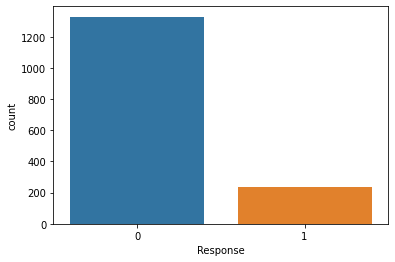

In [ ]:
sns.countplot(y)

In [ ]:
#Standardizing The Data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
Scaled_X = sc.fit_transform(X)
#Standardizing has no effect on the data

In [ ]:
X_new = new_train.drop(['Response'],axis=1)
y_new = new_train.Response

In [ ]:
#Standardizing The Data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
Scaled_X_new = sc.fit_transform(X_new)
#Standardizing has no effect on the data

In [ ]:
#Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [ ]:
X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(X_new, y_new, test_size=0.2, random_state=42, stratify=y_new)

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier,AdaBoostClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [ ]:
model = XGBClassifier()
#scale_pos_weight=2
weights = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
param_grid = {'scale_pos_weight':weights}
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='f1')
# execute the grid search
grid_result = grid.fit(X, y)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.613950 using {'scale_pos_weight': 4}
0.552147 (0.063651) with: {'scale_pos_weight': 1}
0.595413 (0.069905) with: {'scale_pos_weight': 2}
0.612012 (0.056080) with: {'scale_pos_weight': 3}
0.613950 (0.051296) with: {'scale_pos_weight': 4}
0.598778 (0.058302) with: {'scale_pos_weight': 5}
0.601696 (0.060750) with: {'scale_pos_weight': 6}
0.594181 (0.057800) with: {'scale_pos_weight': 7}
0.582879 (0.057263) with: {'scale_pos_weight': 8}
0.576070 (0.054568) with: {'scale_pos_weight': 9}
0.566716 (0.052312) with: {'scale_pos_weight': 10}
0.563991 (0.046062) with: {'scale_pos_weight': 11}
0.555146 (0.040210) with: {'scale_pos_weight': 12}
0.553934 (0.043895) with: {'scale_pos_weight': 13}
0.550636 (0.046162) with: {'scale_pos_weight': 14}
0.539713 (0.038792) with: {'scale_pos_weight': 15}


XGB Classifier with date features unscaled 0.5925925925925926

XGB Classifier with date features scaled 0.5925925925925926

XGB Classifier without date features unscaled 0.5904761904761905

XGB Classifier without date features scaled 0.5904761904761905

XGB Classifier with date feature unscaled 0.6019417475728155

In [ ]:
model_xgb = XGBClassifier()
#scale_pos_weight=3)
weights = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
param_grid = {'scale_pos_weight':weights}
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model_xgb, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='f1')
# execute the grid search
grid_result = grid.fit(X_new, y_new)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.612817 using {'scale_pos_weight': 3}
0.532254 (0.096151) with: {'scale_pos_weight': 1}
0.604942 (0.060527) with: {'scale_pos_weight': 2}
0.612817 (0.063126) with: {'scale_pos_weight': 3}
0.601163 (0.063020) with: {'scale_pos_weight': 4}
0.595041 (0.067204) with: {'scale_pos_weight': 5}
0.590002 (0.063197) with: {'scale_pos_weight': 6}
0.587107 (0.056118) with: {'scale_pos_weight': 7}
0.580289 (0.062441) with: {'scale_pos_weight': 8}
0.574867 (0.065312) with: {'scale_pos_weight': 9}
0.559528 (0.050207) with: {'scale_pos_weight': 10}
0.556344 (0.046431) with: {'scale_pos_weight': 11}
0.557036 (0.056300) with: {'scale_pos_weight': 12}
0.550975 (0.054540) with: {'scale_pos_weight': 13}
0.545125 (0.050460) with: {'scale_pos_weight': 14}
0.544927 (0.036239) with: {'scale_pos_weight': 15}


XGB Classifier with date features and polynomials unscaled 0.5904761904761905

XGB Classifier with date features and polynomials scaled 0.5904761904761905

XGB Classifier without date features and polynomials unscaled 0.627450980392157

XGB Classifier without date features and polynomials scaled 0.627450980392157

In [ ]:
model_ltb = ltb.LGBMClassifier()
#scale_pos_weight=5
weights = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
param_grid = {'scale_pos_weight':weights}
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model_ltb, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='f1')
# execute the grid search
grid_result = grid.fit(X, y)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.613276 using {'scale_pos_weight': 5}
0.565872 (0.072799) with: {'scale_pos_weight': 1}
0.582300 (0.080782) with: {'scale_pos_weight': 2}
0.600192 (0.064969) with: {'scale_pos_weight': 3}
0.595673 (0.066837) with: {'scale_pos_weight': 4}
0.613276 (0.066341) with: {'scale_pos_weight': 5}
0.587193 (0.060872) with: {'scale_pos_weight': 6}
0.607017 (0.064033) with: {'scale_pos_weight': 7}
0.600563 (0.070417) with: {'scale_pos_weight': 8}
0.593745 (0.068086) with: {'scale_pos_weight': 9}
0.598082 (0.074139) with: {'scale_pos_weight': 10}
0.603010 (0.065511) with: {'scale_pos_weight': 11}
0.599933 (0.066358) with: {'scale_pos_weight': 12}
0.596619 (0.057204) with: {'scale_pos_weight': 13}
0.602755 (0.059577) with: {'scale_pos_weight': 14}
0.599418 (0.066287) with: {'scale_pos_weight': 15}


LGBM Classifier with date features unscaled 0.5894736842105263

LGBM Classifier with date features scaled 0.5567010309278351

LGBM Classifier with date features unscaled 0.5979381443298969

LGBM Classifier without date features scaled 0.5833333333333334

In [ ]:
model_ltb = ltb.LGBMClassifier()
#scale_pos_weight=9)
weights = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
param_grid = {'scale_pos_weight':weights}
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model_ltb, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='f1')
# execute the grid search
grid_result = grid.fit(X_new, y_new)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.616056 using {'scale_pos_weight': 12}
0.556897 (0.074354) with: {'scale_pos_weight': 1}
0.570048 (0.061274) with: {'scale_pos_weight': 2}
0.588199 (0.068358) with: {'scale_pos_weight': 3}
0.587142 (0.065075) with: {'scale_pos_weight': 4}
0.594221 (0.063872) with: {'scale_pos_weight': 5}
0.595314 (0.065682) with: {'scale_pos_weight': 6}
0.590998 (0.053367) with: {'scale_pos_weight': 7}
0.605668 (0.056741) with: {'scale_pos_weight': 8}
0.610161 (0.066425) with: {'scale_pos_weight': 9}
0.599765 (0.064654) with: {'scale_pos_weight': 10}
0.603942 (0.062377) with: {'scale_pos_weight': 11}
0.616056 (0.064589) with: {'scale_pos_weight': 12}
0.608440 (0.055373) with: {'scale_pos_weight': 13}
0.607158 (0.061648) with: {'scale_pos_weight': 14}
0.608085 (0.055332) with: {'scale_pos_weight': 15}


LGBM Classifier with date features with polynomials unscaled 0.6041666666666666

LGBM Classifier with date features with polynomials scaled 0.5490196078431373

LGBM Classifier without date features with polynomials unscaled 0.5833333333333334

LGBM Classifier without date features with polynomials unscaled 0.5858585858585857


In [ ]:
model_cbc = ctb.CatBoostClassifier()
#scale_pos_weight=3)
weights = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
param_grid = {'scale_pos_weight':weights}
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model_cbc, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='f1')
# execute the grid search
grid_result = grid.fit(X, y)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Learning rate set to 0.012484
0:	learn: 0.6865897	total: 6.83ms	remaining: 6.82s
1:	learn: 0.6785865	total: 10.3ms	remaining: 5.14s
2:	learn: 0.6718846	total: 13.5ms	remaining: 4.5s
3:	learn: 0.6660615	total: 16.7ms	remaining: 4.16s
4:	learn: 0.6609520	total: 19.9ms	remaining: 3.95s
5:	learn: 0.6530923	total: 23.2ms	remaining: 3.85s
6:	learn: 0.6492494	total: 24.9ms	remaining: 3.54s
7:	learn: 0.6423538	total: 28.1ms	remaining: 3.49s
8:	learn: 0.6372696	total: 31.3ms	remaining: 3.45s
9:	learn: 0.6310634	total: 34.5ms	remaining: 3.41s
10:	learn: 0.6267672	total: 37.6ms	remaining: 3.38s
11:	learn: 0.6214893	total: 40.8ms	remaining: 3.36s
12:	learn: 0.6141877	total: 44ms	remaining: 3.34s
13:	learn: 0.6101562	total: 47.3ms	remaining: 3.33s
14:	learn: 0.6044434	total: 50.6ms	remaining: 3.33s
15:	learn: 0.5999370	total: 53.8ms	remaining: 3.31s
16:	learn: 0.5950909	total: 57ms	remaining: 3.29s
17:	learn: 0.5914979	total: 60.4ms	remaining: 3.3s
18:	learn: 0.5860717	total: 63.8ms	remaining: 3.29

CatBoostClassifier with date features unscaled 0.6226415094339622

CatBoostClassifier with date features scaled 0.6226415094339622

CatBoostClassifier with date features unscaled 0.6153846153846153

CatBoostClassifier with date features scaled 0.6153846153846153

In [ ]:
model_cbc = ctb.CatBoostClassifier()
#scale_pos_weight=7)
weights = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
param_grid = {'scale_pos_weight':weights}
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = RandomizedSearchCV(estimator=model_cbc, param_distributions=param_grid, n_jobs=-1, cv=cv, scoring='f1')
# execute the grid search
grid_result = grid.fit(X_new, y_new)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Learning rate set to 0.012484
0:	learn: 0.6873232	total: 19.5ms	remaining: 19.5s
1:	learn: 0.6812072	total: 28.7ms	remaining: 14.3s
2:	learn: 0.6754965	total: 37.7ms	remaining: 12.5s
3:	learn: 0.6688315	total: 46.9ms	remaining: 11.7s
4:	learn: 0.6617681	total: 56ms	remaining: 11.1s
5:	learn: 0.6559938	total: 65.1ms	remaining: 10.8s
6:	learn: 0.6515323	total: 74.2ms	remaining: 10.5s
7:	learn: 0.6451229	total: 83.4ms	remaining: 10.3s
8:	learn: 0.6395632	total: 92.1ms	remaining: 10.1s
9:	learn: 0.6348343	total: 101ms	remaining: 10s
10:	learn: 0.6293863	total: 110ms	remaining: 9.89s
11:	learn: 0.6256738	total: 119ms	remaining: 9.78s
12:	learn: 0.6188056	total: 128ms	remaining: 9.7s
13:	learn: 0.6132157	total: 137ms	remaining: 9.63s
14:	learn: 0.6080506	total: 146ms	remaining: 9.56s
15:	learn: 0.6030976	total: 155ms	remaining: 9.52s
16:	learn: 0.5992498	total: 164ms	remaining: 9.49s
17:	learn: 0.5954444	total: 180ms	remaining: 9.81s
18:	learn: 0.5902586	total: 205ms	remaining: 10.6s
19:	lea

CatBoostClassifier with date features scaled 0.5669291338582677

CatBoostClassifier with date features unscaled 0.6050420168067226

CatBoostClassifier with date features scaled 0.6050420168067226

No handles with labels found to put in legend.


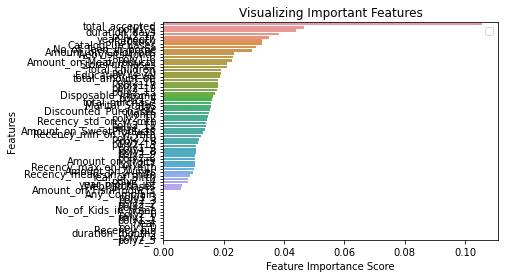

In [ ]:
model = XGBClassifier(scale_pos_weight=3)
model.fit(X_new_train, y_new_train)
feature_imp = pd.Series(model.feature_importances_,index=X_new.columns).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [ ]:
feature_imp.head(50)

total_accepted             0.112754
duration_days              0.050540
poly1_5                    0.047572
Amount_on_GoldProds        0.040982
poly2_17                   0.034392
Recency                    0.034267
CatalogPurchases           0.033059
No_of_Teen_in_home         0.032153
year_month                 0.031650
WebVisitsMonth             0.024606
poly1_6                    0.023747
Amount_on_MeatProducts     0.023491
poly2_16                   0.023481
total_amount_on            0.023239
StorePurchases             0.022425
Education_Level            0.021705
poly2_19                   0.019787
Disposable_Income          0.019246
day                        0.018931
total_children             0.018306
poly1_4                    0.018054
poly1_7                    0.017091
poly2_11                   0.016048
Marital_Status             0.015931
total_purchase             0.015885
poly2_13                   0.015760
poly2_18                   0.015499
Month                      0

In [ ]:
model_rfc = RandomForestClassifier()
model_rfc.fit(X_train,y_train)
feature_imp = pd.Series(model_rfc.feature_importances_,index=X.columns).sort_values(ascending=False)
#feature_imp

No handles with labels found to put in legend.


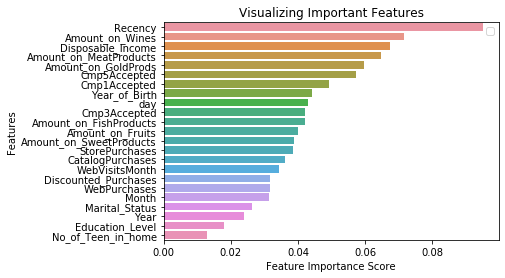

In [ ]:
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [ ]:
model_CBC = ctb.CatBoostClassifier(scale_pos_weight=10)
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
#scores = cross_val_score(model_CBC, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1)
# summarize performance
#print('Mean f1: %.3f' % mean(scores))
model_CBC.fit(X_train,y_train)
expected_y  = y_test
predicted_y = model_CBC.predict(X_test)
print(metrics.classification_report(expected_y, predicted_y))
print(metrics.confusion_matrix(expected_y, predicted_y))

In [ ]:
model_ltb = ltb.LGBMClassifier(random_state=1, learning_rate=0.12)
model_ltb.fit(X_train,y_train)
expected_y  = y_test
predicted_y = model_ltb.predict(X_test)
print(metrics.classification_report(expected_y, predicted_y))
print(metrics.confusion_matrix(expected_y, predicted_y))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       266
           1       0.68      0.44      0.53        48

    accuracy                           0.88       314
   macro avg       0.79      0.70      0.73       314
weighted avg       0.87      0.88      0.87       314

[[256  10]
 [ 27  21]]


In [ ]:
model_xgb = XGBClassifier()
weights = [1, 10, 25, 50, 75, 99, 100, 1000]
max_depth = [1,2,3,4,5,6,7,8,9,10]
n_estimators = [100,200,300,400,500,600,700]
learning_rate = np.linspace(0,0.2,5)
param_grid = {'learning_rate':learning_rate}
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model_xgb, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='f1')
# execute the grid search
grid_result = grid.fit(X_train, y_train)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.548809 using {'learning_rate': 0.2}
0.000000 (0.000000) with: {'learning_rate': 0.0}
0.486365 (0.099362) with: {'learning_rate': 0.05}
0.524102 (0.104094) with: {'learning_rate': 0.1}
0.543159 (0.110946) with: {'learning_rate': 0.15000000000000002}
0.548809 (0.118759) with: {'learning_rate': 0.2}


In [ ]:
model_xgb1 = XGBClassifier(scale_pos_weight=10,max_depth=5,n_estimators=600,learning_rate=0.2)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model_xgb1, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1)
# summarize performance
print('Mean f1: %.3f' % mean(scores))


Mean f1: 0.575


In [ ]:
model_etc.fit(X_train,y_train)
val_pred1=model_etc.predict(X_test)
test_pred1=model_etc.predict(test)
val_pred1=pd.DataFrame(val_pred1)
test_pred1=pd.DataFrame(test_pred1)

model_dtc.fit(X_train,y_train)
val_pred2=model_dtc.predict(X_test)
test_pred2=model_dtc.predict(test)
val_pred2=pd.DataFrame(val_pred2)
test_pred2=pd.DataFrame(test_pred2)

model_bc.fit(X_train,y_train)
val_pred3=model_bc.predict(X_test)
test_pred3=model_bc.predict(test)
val_pred3=pd.DataFrame(val_pred3)
test_pred3=pd.DataFrame(test_pred3)

model_rfc.fit(X_train,y_train)
val_pred4=model_rfc.predict(X_test)
test_pred4=model_rfc.predict(test)
val_pred4=pd.DataFrame(val_pred4)
test_pred4=pd.DataFrame(test_pred4)

model_abc.fit(X_train, y_train)
val_pred5=model_abc.predict(X_test)
test_pred5=model_abc.predict(test)
val_pred5=pd.DataFrame(val_pred5)
test_pred5=pd.DataFrame(test_pred5)

model_ltb.fit(X_train,y_train)
val_pred6=model_ltb.predict(X_test)
test_pred6=model_ltb.predict(test)
val_pred6=pd.DataFrame(val_pred6)
test_pred6=pd.DataFrame(test_pred6)

model_xgb.fit(X_train,y_train)
val_pred7 =model_xgb.predict(X_test)
test_pred7=model_xgb.predict(test)
val_pred7=pd.DataFrame(val_pred7)
test_pred7=pd.DataFrame(test_pred7)

model_CBC.fit(X_train,y_train)
val_pred8=model_CBC.predict(X_test)
test_pred8=model_CBC.predict(test)
val_pred8=pd.DataFrame(val_pred8)
test_pred8=pd.DataFrame(test_pred8)

model_gbc.fit(X_train,y_train)
val_pred9=model_gbc.predict(X_test)
test_pred9=model_gbc.predict(test)
val_pred9=pd.DataFrame(val_pred9)
test_pred9=pd.DataFrame(test_pred9)


Stack = np.column_stack((val_pred1,val_pred2,val_pred3,val_pred4,val_pred5,val_pred6,val_pred7,val_pred8,val_pred9))
Stack_test= np.column_stack((test_pred1,test_pred2,test_pred3,test_pred4,test_pred5,test_pred6,test_pred7,test_pred8,test_pred9))
Stack
model = LogisticRegression()
model.fit(Stack,y_test)
#expected_y  = y_test
predicted_y = model.predict(Stack_test)
predicted_y

Learning rate set to 0.006831
0:	learn: 0.6886659	total: 1.78ms	remaining: 1.78s
1:	learn: 0.6850091	total: 3.6ms	remaining: 1.8s
2:	learn: 0.6810040	total: 5.36ms	remaining: 1.78s
3:	learn: 0.6767253	total: 7.16ms	remaining: 1.78s
4:	learn: 0.6725622	total: 8.89ms	remaining: 1.77s
5:	learn: 0.6681535	total: 12.3ms	remaining: 2.04s
6:	learn: 0.6645166	total: 14.2ms	remaining: 2.01s
7:	learn: 0.6602253	total: 16ms	remaining: 1.98s
8:	learn: 0.6562724	total: 17.9ms	remaining: 1.97s
9:	learn: 0.6528309	total: 20.2ms	remaining: 2s
10:	learn: 0.6490280	total: 22ms	remaining: 1.98s
11:	learn: 0.6455284	total: 23.8ms	remaining: 1.96s
12:	learn: 0.6418436	total: 25.6ms	remaining: 1.94s
13:	learn: 0.6381247	total: 27.4ms	remaining: 1.93s
14:	learn: 0.6346911	total: 29.2ms	remaining: 1.92s
15:	learn: 0.6313520	total: 31ms	remaining: 1.91s
16:	learn: 0.6280233	total: 32.8ms	remaining: 1.9s
17:	learn: 0.6244269	total: 34.6ms	remaining: 1.89s
18:	learn: 0.6208297	total: 36.3ms	remaining: 1.88s
19:	

array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,

In [ ]:
Stack

array([[0, 0, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [0, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1]])

In [ ]:
submission['Response'] = predicted_y
submission

,ID,Response
0,ID_ZPMABNVX,0
1,ID_WFE91NAA,0
2,ID_JV11RBRK,0
3,ID_6B7SVKY9,1
4,ID_GOVUZ545,1
...,...,...
667,ID_1D68PV28,0
668,ID_TM6CYFZO,0
669,ID_VHR666SC,0
670,ID_O852YAO1,0


In [ ]:
submission.to_csv('SampleSubmission2.csv',index=False)

In [ ]:
from google.colab import files
files.download('SampleSubmission2.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>